In [28]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import List

In [2]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [4]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [6]:
data_fake = pd.read_csv("Fake.csv")
data_true = pd.read_csv("True.csv")

In [7]:
data_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [8]:
data_fake.drop(labels=["title", "subject", "date"], axis=1, inplace=True)
data_fake["target"] = 1

In [9]:
data_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [10]:
data_true.drop(labels=["title", "subject", "date"], axis=1, inplace=True)
data_true["target"] = 0

In [11]:
data = pd.concat((data_true, data_fake), axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   target  44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [18]:
data_sample = data.sample(10000, random_state=RANDOM_STATE)
X, y = data_sample.text.values, data_sample.target.values

In [29]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
def text_tokenization(texts: List[str]):
    tokenized_texts = []
    for text in tqdm(texts):
        tokenized_text = word_tokenize(text.lower())
        tokenized_texts.append(tokenized_text)
    return tokenized_texts


sw = stopwords.words("english")


def del_stopwords(texts: List[List[str]]):
    cleaned_texts = []
    for text in tqdm(texts):
        cleaned_text = [word for word in text if word not in sw]
        cleaned_texts.append(cleaned_text)
    return cleaned_texts

In [31]:
X_tokenized = text_tokenization(X)
X_cleaned = del_stopwords(X_tokenized)

100%|██████████| 10000/10000 [00:07<00:00, 1253.58it/s]


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y, test_size=TEST_SIZE, shuffle=True, stratify=y, random_state=RANDOM_STATE
)

In [38]:
max_tokens = 2000

In [39]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield text


train_iter = iter(X_train)
vocab = build_vocab_from_iterator(
    yield_tokens(train_iter), specials=["<unk>"], max_tokens=max_tokens
)
vocab.set_default_index(vocab["<unk>"])

In [49]:
# MAX_LEN = max([len(text) for text in X_train])
MAX_LEN = 1000
MAX_LEN

1000

In [50]:
def tokens2idx(batch):
    texts, labels = [], []
    for text, label in batch:
        processed_text = torch.tensor(vocab(text), dtype=torch.int64)
        processed_text = processed_text[: MAX_LEN]
        texts.append(F.pad(processed_text, (0, MAX_LEN - processed_text.shape[0])))
        labels.append(label)
    texts = torch.stack(texts)
    labels = torch.tensor(labels, dtype=torch.float32)
    return texts.to(device), labels.to(device)

In [51]:
def yield_data(texts, labels):
    for text, label in zip(texts, labels):
        yield text, label

In [52]:
BATCH_SIZE = 32

In [53]:
train_dataset = to_map_style_dataset(yield_data(X_train, y_train))
test_dataset = to_map_style_dataset(yield_data(X_test, y_test))

num_train = int(len(train_dataset) * 0.9)
train_dataset, val_dataset = torch.utils.data.dataset.random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokens2idx
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokens2idx
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokens2idx
)

In [54]:
def train(model, optimizer, criterion, epochs):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        with tqdm(train_dataloader, unit="batch") as tepoch:
            for i, (x_batch, y_batch) in enumerate(tepoch):
                optimizer.zero_grad()
                y_pred = model(x_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                train_losses.append(loss.item())
                loss.backward()
                optimizer.step()
                roc_auc = roc_auc_score(
                    y_batch.cpu().detach().numpy(), y_pred.cpu().detach().numpy()
                )
                tepoch.set_postfix(train_loss=loss.item(), train_roc_auc=roc_auc)
        model.eval()
        with torch.no_grad():
            with tqdm(val_dataloader, unit="batch") as tepoch:
                for i, (x_batch, y_batch) in enumerate(tepoch):
                    y_pred = model(x_batch).squeeze()
                    loss = criterion(y_pred, y_batch).item()
                    val_losses.append(loss)
                    roc_auc = roc_auc_score(
                        y_batch.cpu().detach().numpy(), y_pred.cpu().detach().numpy()
                    )
                    tepoch.set_postfix(val_loss=loss, val_roc_auc=roc_auc)
    return train_losses, val_losses

In [55]:
emb_size = 128

In [83]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=max_tokens, emb_size=emb_size, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(num_embeddings=input_size, embedding_dim=emb_size)
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=self.hidden_size,
            dropout=0.3,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )
        self.fc1 = nn.Linear(2 * hidden_size, 1)

    def forward(self, x):
        out = self.emb(x)
        out, (h_n, c_n) = self.lstm(out)
        out = self.fc1(out[:, -1])
        return out

In [97]:
epochs = 7
lstm_model = LSTMModel()
lstm_model.to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.03)
criterion = nn.BCEWithLogitsLoss()

In [98]:
history = train(lstm_model, optimizer, criterion, epochs)

100%|██████████| 25/25 [00:00<00:00, 64.18batch/s, val_loss=0.303, val_roc_auc=0.905]


In [99]:
train_losses, val_losses = history

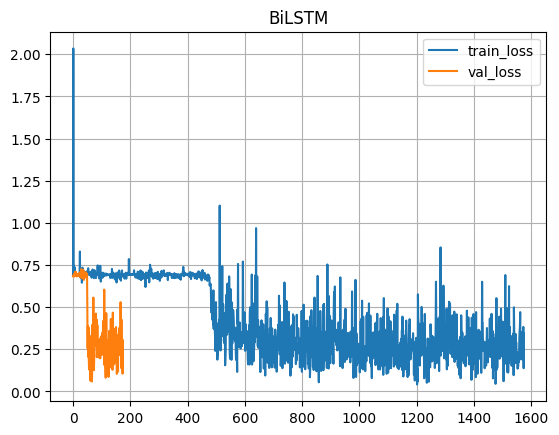

In [100]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["train_loss", "val_loss"])
plt.title("BiLSTM")
plt.grid()

In [66]:
torch.cuda.empty_cache()

In [93]:
class CNNModel(nn.Module):
    def __init__(self, input_size):
        self.input_size = input_size
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=5)
        self.mp = nn.MaxPool1d(kernel_size=2, stride=1)
        self.do = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.input_size - 9, 1)

    def forward(self, x):
        x = x.float()
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.mp(x)
        x = self.do(x)
        x = x.view(BATCH_SIZE, -1)
        x = self.fc1(x)
        return x

In [94]:
epochs = 7
cnn_model = CNNModel(MAX_LEN)
cnn_model.to(device)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [95]:
history_cnn = train(cnn_model, optimizer, criterion, epochs)

100%|██████████| 25/25 [00:00<00:00, 111.25batch/s, val_loss=0.53, val_roc_auc=0.827]


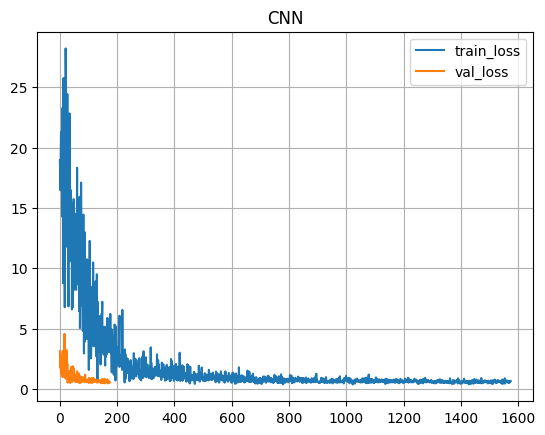

In [96]:
train_losses, val_losses = history_cnn
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["train_loss", "val_loss"])
plt.title("CNN")
plt.grid()